In [1]:
!pip install --upgrade --no-cache-dir gdown
!gdown 1QTi7dJtNAfFR5mG0rd8K3ZGvEIfSn_DS
!unzip PersianData.zip

Downloading...
From: https://drive.google.com/uc?id=1QTi7dJtNAfFR5mG0rd8K3ZGvEIfSn_DS
To: /content/PersianData.zip
100% 7.46k/7.46k [00:00<00:00, 15.5MB/s]
Archive:  PersianData.zip
  inflating: 1.jpg                   
  inflating: 2.jpg                   
  inflating: 3.jpg                   
  inflating: 4.jpg                   
  inflating: 5.jpg                   


In [13]:
import numpy as np
from PIL import Image, ImageDraw
import random
import matplotlib.pyplot as plt

def convertImageToBinary(path):
    """
    Convert an image to a binary representation with -1 for white and 1 for black.

    Args:
        path (str): The file path to the input image.

    Returns:
        list: A binary representation of the image where white is represented by -1 and black by 1.
    """
    # Open the image file.
    image = Image.open(path)

    # Create a drawing tool for manipulating the image.
    draw = ImageDraw.Draw(image)

    # Determine the image's width and height in pixels.
    width = image.size[0]
    height = image.size[1]

    # Load pixel values for the image.
    pix = image.load()

    # Define a factor for intensity thresholding.
    factor = 1

    # Initialize an empty list to store the binary representation.
    binary_representation = []

    # Loop through all pixels in the image.
    for i in range(width):
        for j in range(height):
            # Extract the Red, Green, and Blue (RGB) values of the pixel.
            red = pix[i, j][0]
            green = pix[i, j][1]
            blue = pix[i, j][2]

            # Calculate the total intensity of the pixel.
            total_intensity = red + green + blue

            # Determine whether the pixel should be white or black based on the intensity.
            if total_intensity > (((255 + factor) // 2) * 3):
                red, green, blue = 255, 255, 255  # White pixel
                binary_representation.append(-1)
            else:
                red, green, blue = 0, 0, 0  # Black pixel
                binary_representation.append(1)

            # Set the pixel color accordingly.
            draw.point((i, j), (red, green, blue))

    # Clean up the drawing tool.
    del draw

    # Return the binary representation of the image.
    return binary_representation

def generateNoisyImages():
    # List of image file paths
    image_paths = [
        "/content/1.jpg",
        "/content/2.jpg",
        "/content/3.jpg",
        "/content/4.jpg",
        "/content/5.jpg"
    ]

    for i, image_path in enumerate(image_paths, start=1):
        noisy_image_path = f"/content/noisy{i}.jpg"
        getNoisyBinaryImage(image_path, noisy_image_path)
        print(f"Noisy image for {image_path} generated and saved as {noisy_image_path}")

def getNoisyBinaryImage(input_path, output_path):
    """
    Add noise to an image and save it as a new file.

    Args:
        input_path (str): The file path to the input image.
        output_path (str): The file path to save the noisy image.
    """
    # Open the input image.
    image = Image.open(input_path)

    # Create a drawing tool for manipulating the image.
    draw = ImageDraw.Draw(image)

    # Determine the image's width and height in pixels.
    width = image.size[0]
    height = image.size[1]

    # Load pixel values for the image.
    pix = image.load()

    # Define a factor for introducing noise.
    noise_factor = 500

    # Loop through all pixels in the image.
    for i in range(width):
        for j in range(height):
            # Generate a random noise value within the specified factor.
            rand = random.randint(-noise_factor, noise_factor)

            # Add the noise to the Red, Green, and Blue (RGB) values of the pixel.
            red = pix[i, j][0] + rand
            green = pix[i, j][1] + rand
            blue = pix[i, j][2] + rand

            # Ensure that RGB values stay within the valid range (0-255).
            if red < 0:
                red = 0
            if green < 0:
                green = 0
            if blue < 0:
                blue = 0
            if red > 255:
                red = 255
            if green > 255:
                green = 255
            if blue > 255:
                blue = 255

            # Set the pixel color accordingly.
            draw.point((i, j), (red, green, blue))

    # Save the noisy image as a file.
    image.save(output_path, "JPEG")

    # Clean up the drawing tool.
    del draw

class HopfieldNetwork:
    def __init__(self):
        self.W = None  # Weight matrix
        self.num_neurons = 0

    def train(self, patterns):
        """
        Train the Hopfield network using the provided patterns.

        Args:
            patterns (list of numpy arrays): Each pattern should be a 1D numpy array with -1 and 1 values.
        """
        num_patterns = len(patterns)
        self.num_neurons = patterns[0].size
        self.W = np.zeros((self.num_neurons, self.num_neurons))

        print("Training the Hopfield network...")

        # Mean-center the patterns
        mean_pattern = np.mean(patterns, axis=0)
        for pattern in patterns:
            centered_pattern = pattern - mean_pattern
            self.W += np.outer(centered_pattern, centered_pattern)

        # Ensure no self-connections
        np.fill_diagonal(self.W, 0)

        # Normalize weights by the number of neurons
        self.W /= self.num_neurons
        print("Training complete.")

    def predict(self, input_pattern, max_iterations=20):
        """
        Predict the pattern the network converges to, starting from an initial input pattern.

        Args:
            input_pattern (numpy array): Initial pattern (1D array of -1 and 1 values).
            max_iterations (int): Maximum number of iterations to run.

        Returns:
            numpy array: The converged pattern.
        """
        if self.W is None:
            raise ValueError("The network has not been trained yet.")

        print("Predicting...")
        state = np.copy(input_pattern)

        for iteration in range(max_iterations):
            for neuron in range(self.num_neurons):  # Asynchronous update
                net_input = np.dot(self.W[neuron], state)
                state[neuron] = 1 if net_input > 0 else -1

            new_state = np.sign(self.W @ state)
            new_state[new_state == 0] = state[new_state == 0]  # Handle zeros

            if np.array_equal(new_state, state):
                print(f"Converged after {iteration + 1} iterations.")
                break

            state = new_state

        return state

    def energy(self, pattern):
        """
        Compute the energy of a given pattern.

        Args:
            pattern (numpy array): The pattern to compute the energy for.

        Returns:
            float: Energy of the pattern.
        """
        return -0.5 * pattern @ self.W @ pattern

def match_class(predicted, train_data):
    """
    Find the class that best matches the predicted pattern.

    Args:
        predicted (numpy array): The predicted pattern.
        train_data (list of numpy arrays): The list of training patterns.

    Returns:
        int: The index of the best-matching class (1-indexed).
    """
    # Compute Hamming distance for each training pattern
    similarities = [np.sum(predicted == train) for train in train_data]
    return np.argmax(similarities) + 1  # Class index starts from 1

# Step 1: Convert original images to binary and prepare training data
original_image_paths = [
    "/content/1.jpg",
    "/content/2.jpg",
    "/content/3.jpg",
    "/content/4.jpg",
    "/content/5.jpg"
]

train_data = [np.array(convertImageToBinary(path)) for path in original_image_paths]
generateNoisyImages()
# Step 2: Train the Hopfield Network
hopfield_net = HopfieldNetwork()
hopfield_net.train(train_data)

# Step 3: Convert noisy images to binary
noisy_image_paths = [
    "/content/noisy1.jpg",
    "/content/noisy2.jpg",
    "/content/noisy3.jpg",
    "/content/noisy4.jpg",
    "/content/noisy5.jpg"
]
test_data = [np.array(convertImageToBinary(path)) for path in noisy_image_paths]

# Step 4: Predict using the Hopfield Network
for i, noisy_pattern in enumerate(test_data):
    predicted_pattern = hopfield_net.predict(noisy_pattern)
    predicted_class = match_class(predicted_pattern, train_data)
    print(f"Noisy image {i + 1} belongs to class {predicted_class}")


Noisy image for /content/1.jpg generated and saved as /content/noisy1.jpg
Noisy image for /content/2.jpg generated and saved as /content/noisy2.jpg
Noisy image for /content/3.jpg generated and saved as /content/noisy3.jpg
Noisy image for /content/4.jpg generated and saved as /content/noisy4.jpg
Noisy image for /content/5.jpg generated and saved as /content/noisy5.jpg
Training the Hopfield network...
Training complete.
Predicting...
Converged after 1 iterations.
Noisy image 1 belongs to class 1
Predicting...
Converged after 1 iterations.
Noisy image 2 belongs to class 2
Predicting...
Converged after 1 iterations.
Noisy image 3 belongs to class 3
Predicting...
Converged after 2 iterations.
Noisy image 4 belongs to class 1
Predicting...
Converged after 1 iterations.
Noisy image 5 belongs to class 5


# Model with visualization capabilities

Training the Hopfield network...
Training complete.
Predicting...
Converged after 1 iterations.
Noisy image 1 belongs to class 1


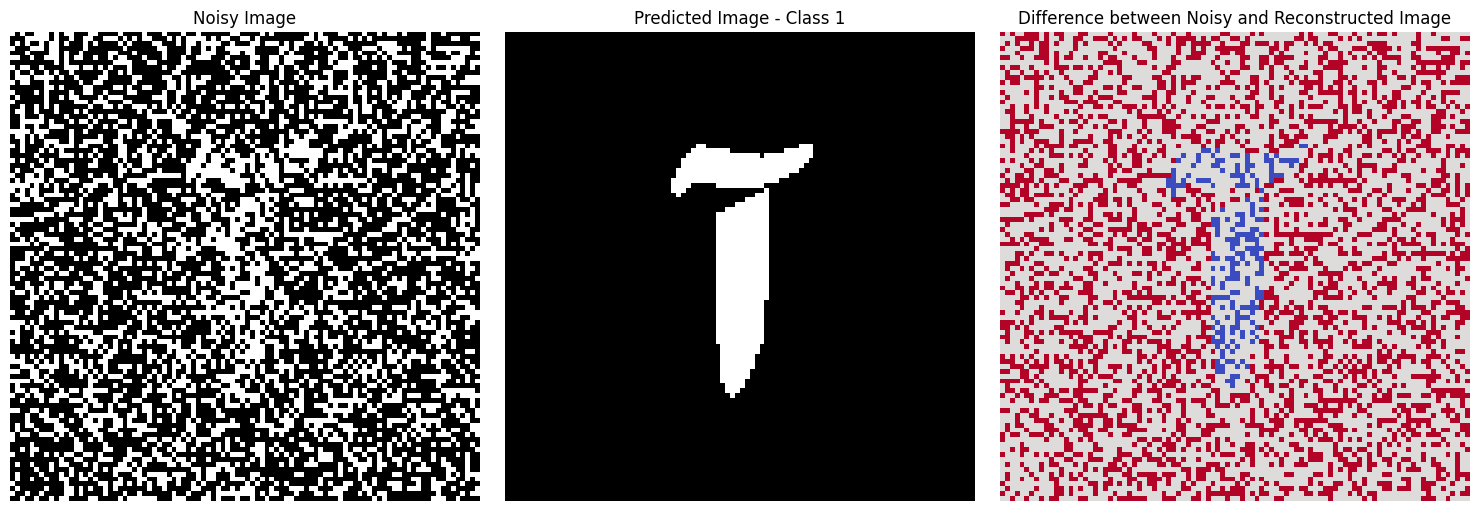

Predicting...
Converged after 1 iterations.
Noisy image 2 belongs to class 2


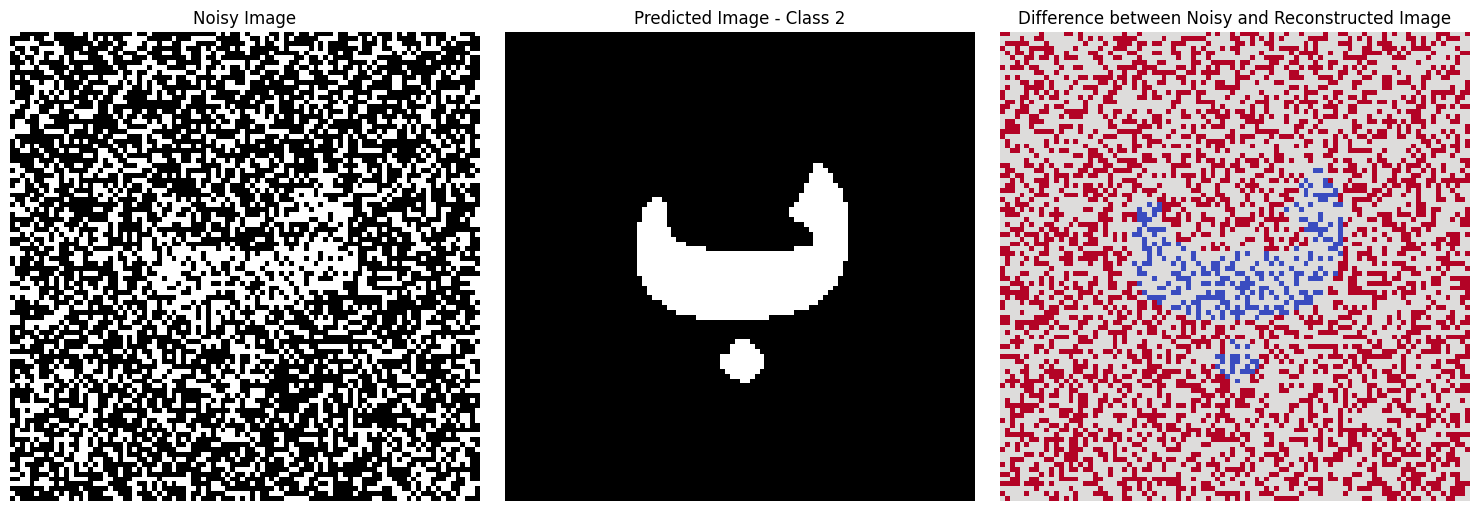

Predicting...
Converged after 1 iterations.
Noisy image 3 belongs to class 3


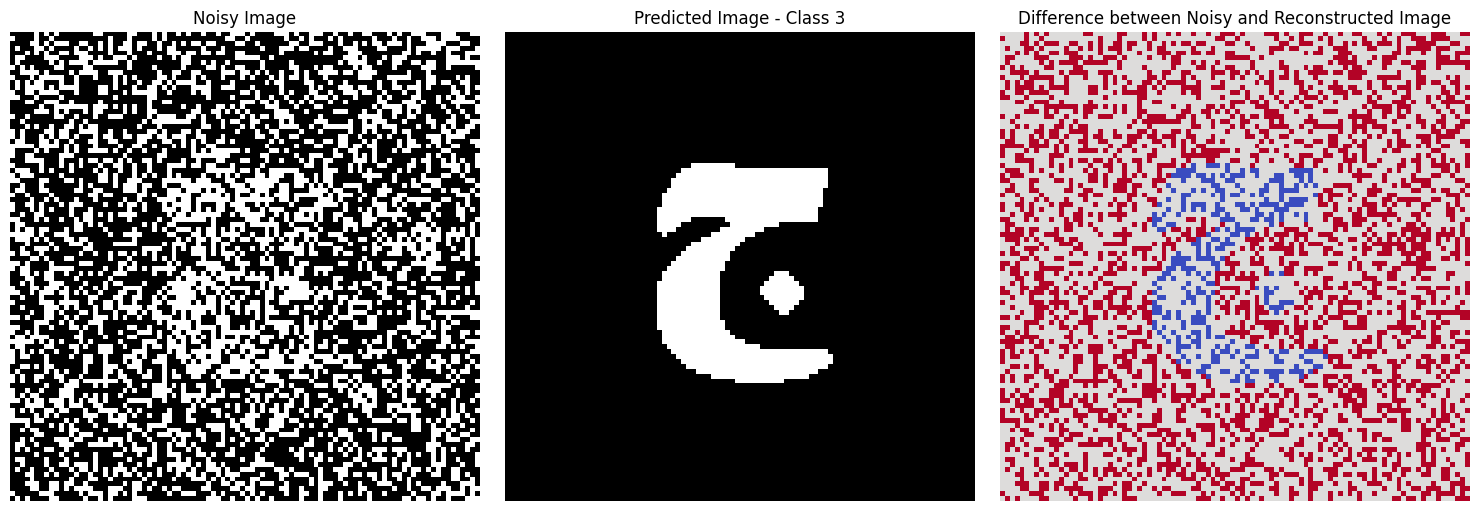

Predicting...
Converged after 2 iterations.
Noisy image 4 belongs to class 2


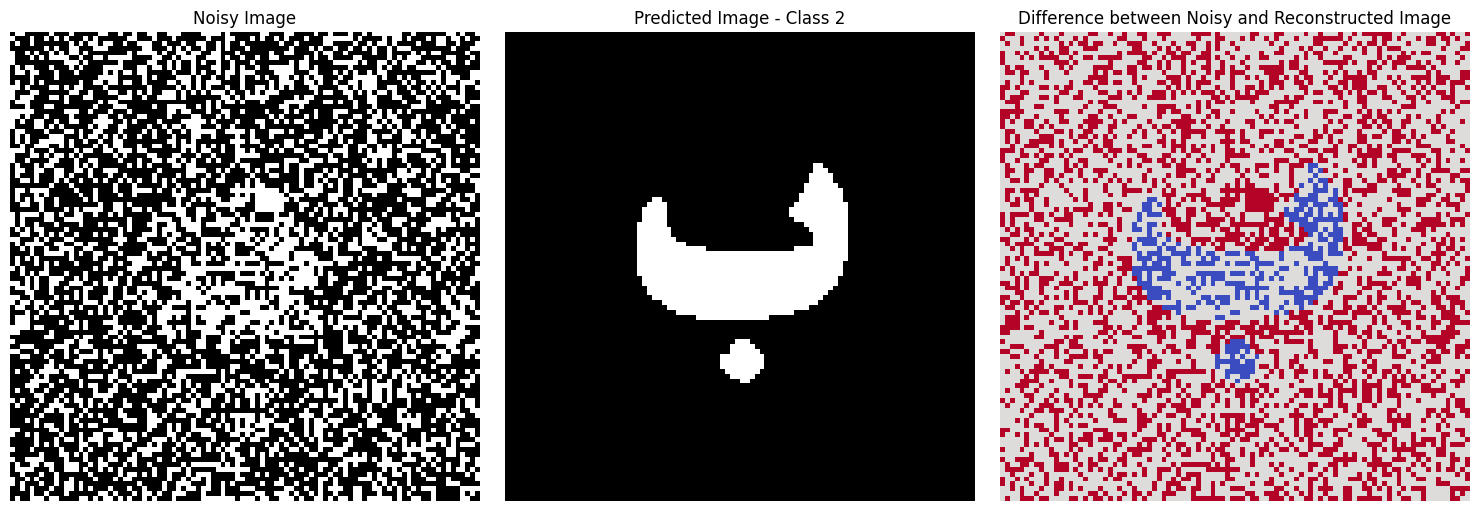

Predicting...
Converged after 2 iterations.
Noisy image 5 belongs to class 5


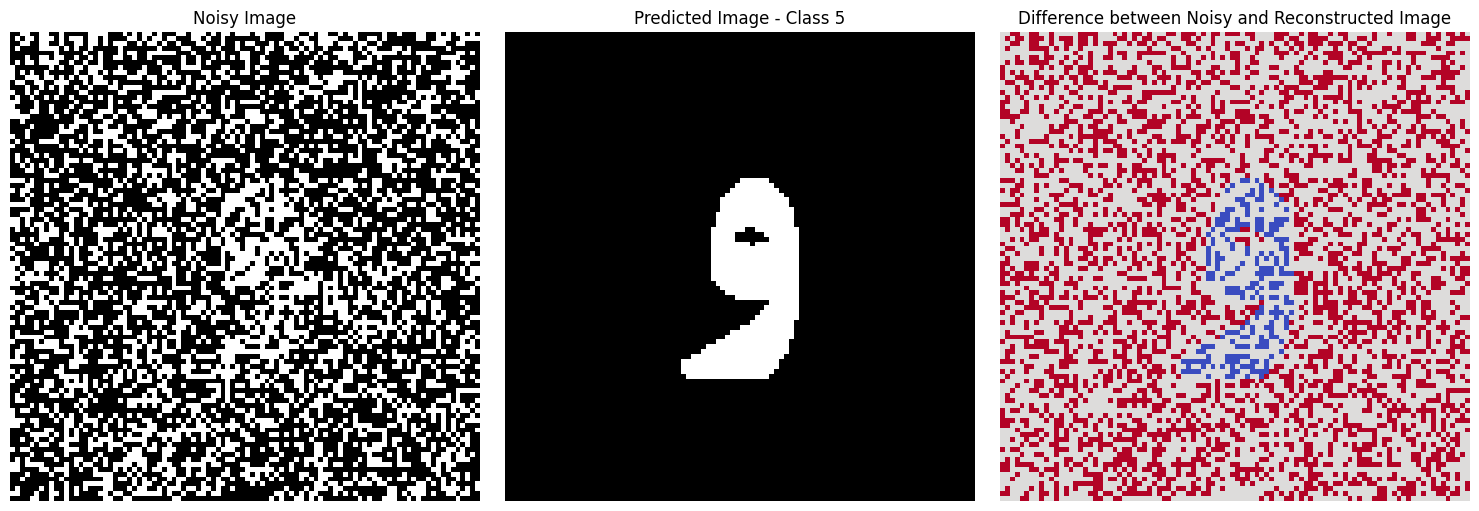

In [16]:
import numpy as np
from PIL import Image, ImageDraw
import random
import matplotlib.pyplot as plt


class HopfieldNetwork:
    def __init__(self):
        self.W = None  # Weight matrix
        self.num_neurons = 0

    def train(self, patterns):
        """
        Train the Hopfield network using the provided patterns.

        Args:
            patterns (list of numpy arrays): Each pattern should be a 1D numpy array with -1 and 1 values.
        """
        num_patterns = len(patterns)
        self.num_neurons = patterns[0].size
        self.W = np.zeros((self.num_neurons, self.num_neurons))

        print("Training the Hopfield network...")

        # Mean-center the patterns
        mean_pattern = np.mean(patterns, axis=0)
        for pattern in patterns:
            centered_pattern = pattern - mean_pattern
            self.W += np.outer(centered_pattern, centered_pattern)

        # Ensure no self-connections
        np.fill_diagonal(self.W, 0)

        # Normalize weights by the number of neurons
        self.W /= self.num_neurons
        print("Training complete.")

    def predict(self, input_pattern, max_iterations=20):
        """
        Predict the pattern the network converges to, starting from an initial input pattern.

        Args:
            input_pattern (numpy array): Initial pattern (1D array of -1 and 1 values).
            max_iterations (int): Maximum number of iterations to run.

        Returns:
            numpy array: The converged pattern.
        """
        if self.W is None:
            raise ValueError("The network has not been trained yet.")

        print("Predicting...")
        state = np.copy(input_pattern)

        for iteration in range(max_iterations):
            for neuron in range(self.num_neurons):  # Asynchronous update
                net_input = np.dot(self.W[neuron], state)
                state[neuron] = 1 if net_input > 0 else -1

            new_state = np.sign(self.W @ state)
            new_state[new_state == 0] = state[new_state == 0]  # Handle zeros

            if np.array_equal(new_state, state):
                print(f"Converged after {iteration + 1} iterations.")
                break

            state = new_state

        return state

    def energy(self, pattern):
        """
        Compute the energy of a given pattern.

        Args:
            pattern (numpy array): The pattern to compute the energy for.

        Returns:
            float: Energy of the pattern.
        """
        return -0.5 * pattern @ self.W @ pattern

def match_class(predicted, train_data):
    """
    Find the class that best matches the predicted pattern.

    Args:
        predicted (numpy array): The predicted pattern.
        train_data (list of numpy arrays): The list of training patterns.

    Returns:
        int: The index of the best-matching class (1-indexed).
    """
    # Compute Hamming distance for each training pattern
    similarities = [np.sum(predicted == train) for train in train_data]
    return np.argmax(similarities) + 1  # Class index starts from 1

def visualize_results(noisy_image, predicted_pattern, predicted_class, class_patterns):
    """
    Visualizes the noisy image, the predicted pattern, and the class it belongs to.

    Args:
        noisy_image (numpy array): The noisy image.
        predicted_pattern (numpy array): The predicted pattern from the network.
        predicted_class (int): The class the predicted pattern belongs to.
        class_patterns (list of numpy arrays): The training patterns.
    """
    # Reshape for visualization
    noisy_image_reshaped = noisy_image.reshape(96, 96)
    predicted_image = class_patterns[predicted_class - 1].reshape(96, 96)  # -1 because class starts from 1

    # Plotting
    plt.figure(figsize=(15, 5))

    # Noisy Image
    plt.subplot(1, 3, 1)
    plt.imshow(noisy_image_reshaped, cmap='gray')
    plt.title("Noisy Image")
    plt.axis('off')

    # Predicted Image
    plt.subplot(1, 3, 2)
    plt.imshow(predicted_image, cmap='gray')
    plt.title(f"Predicted Image - Class {predicted_class}")
    plt.axis('off')

    # Difference
    plt.subplot(1, 3, 3)
    difference = noisy_image_reshaped - predicted_image
    plt.imshow(difference, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title("Difference between Noisy and Reconstructed Image")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Step 1: Convert original images to binary and prepare training data
original_image_paths = [
    "/content/1.jpg",
    "/content/2.jpg",
    "/content/3.jpg",
    "/content/4.jpg",
    "/content/5.jpg"
]
train_data = [np.array(convertImageToBinary(path)) for path in original_image_paths]

# Step 2: Train the Hopfield Network
hopfield_net = HopfieldNetwork()
hopfield_net.train(train_data)

# Step 3: Convert noisy images to binary
noisy_image_paths = [
    "/content/noisy1.jpg",
    "/content/noisy2.jpg",
    "/content/noisy3.jpg",
    "/content/noisy4.jpg",
    "/content/noisy5.jpg"
]
test_data = [np.array(convertImageToBinary(path)) for path in noisy_image_paths]

# Step 4: Predict using the Hopfield Network and visualize results
for i, noisy_pattern in enumerate(test_data):
    predicted_pattern = hopfield_net.predict(noisy_pattern)
    predicted_class = match_class(predicted_pattern, train_data)
    print(f"Noisy image {i + 1} belongs to class {predicted_class}")
    visualize_results(noisy_pattern, predicted_pattern, predicted_class, train_data)


Missing image created and saved as /content/missing1.jpg


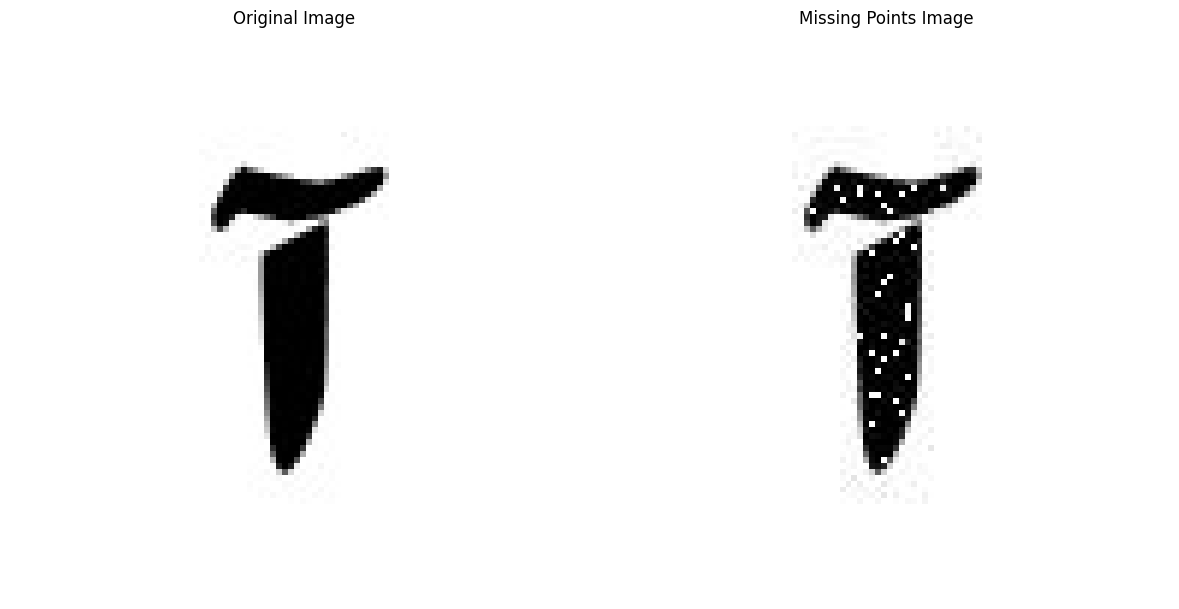

Missing image created and saved as /content/missing2.jpg


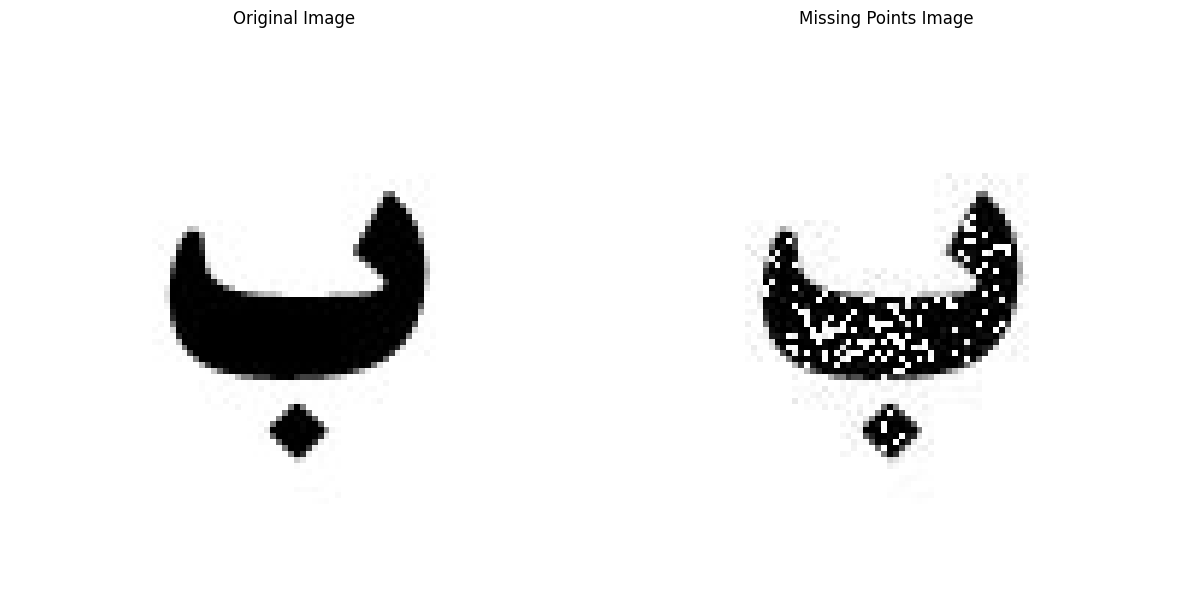

Missing image created and saved as /content/missing3.jpg


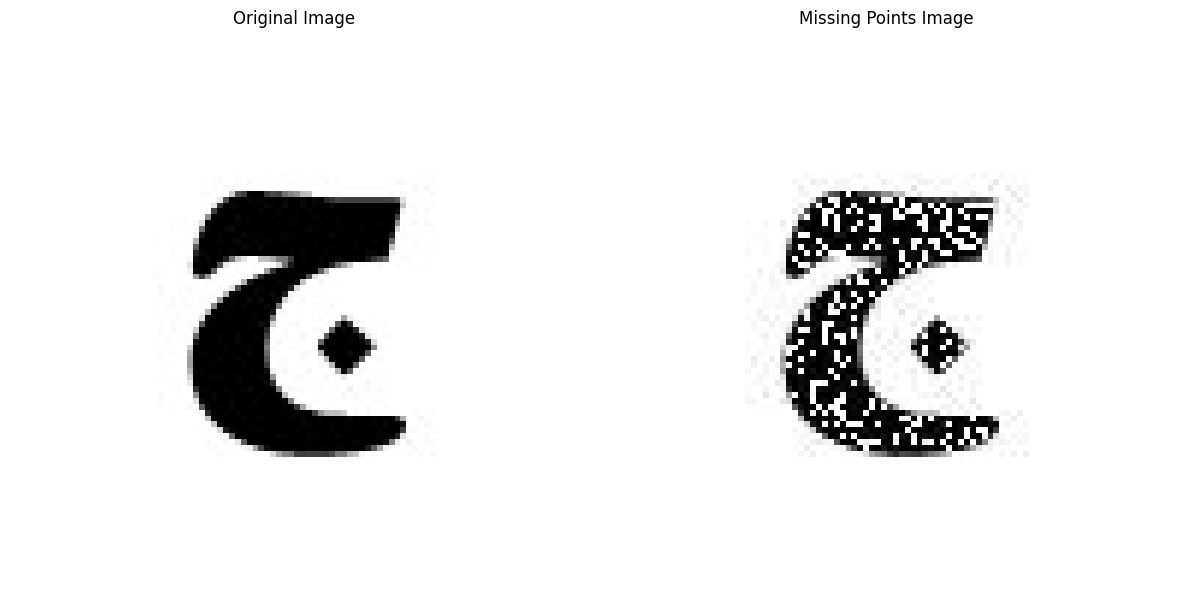

Missing image created and saved as /content/missing4.jpg


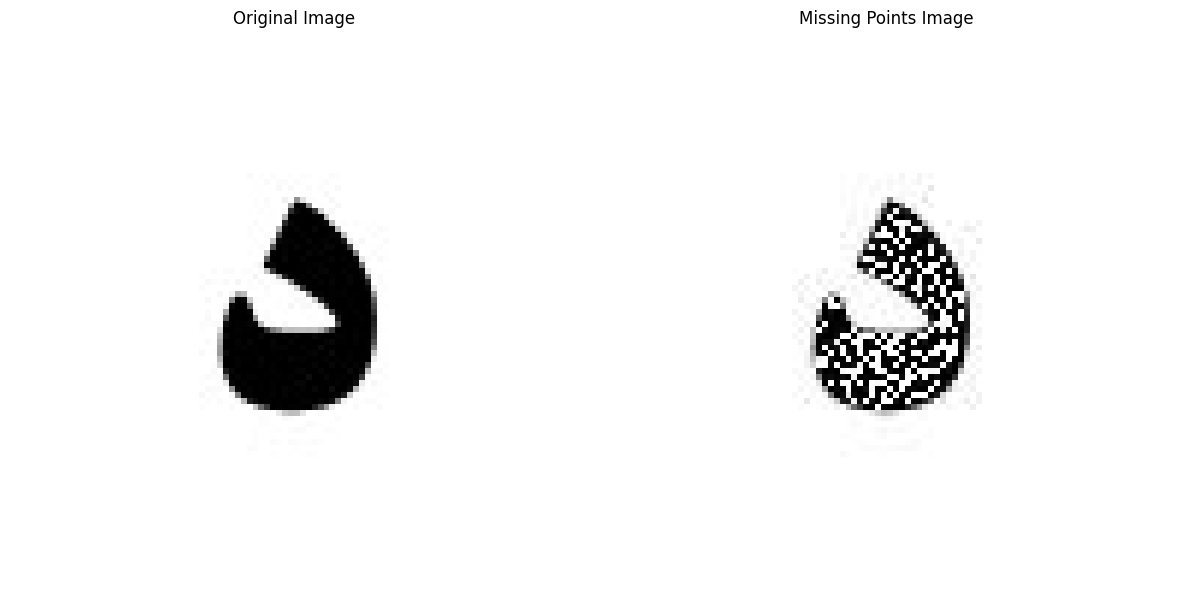

Missing image created and saved as /content/missing5.jpg


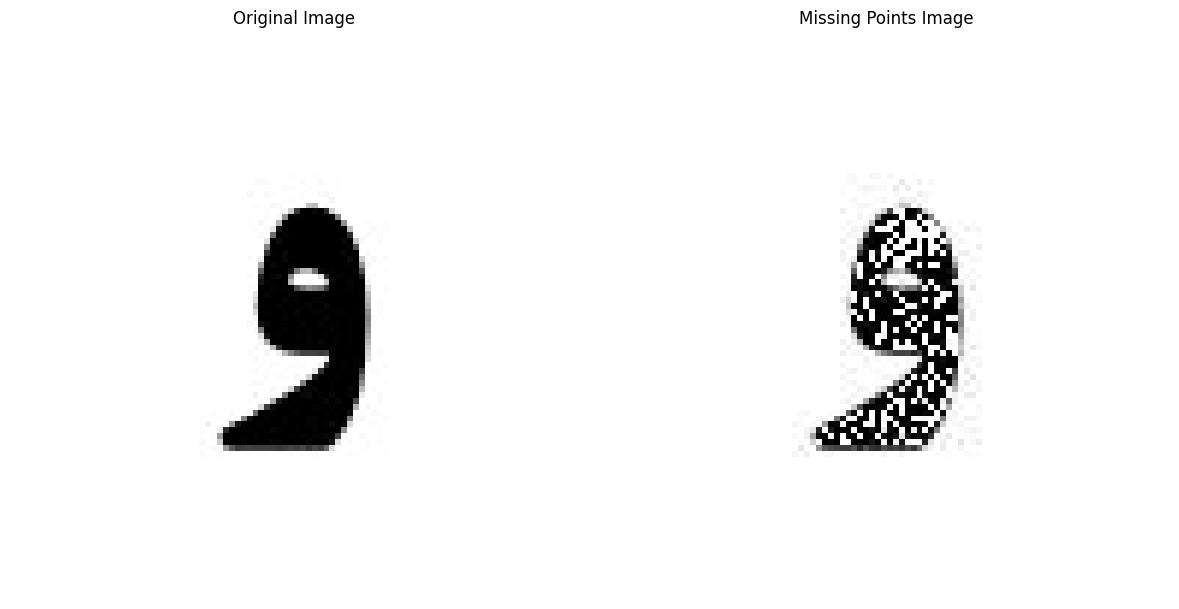

In [14]:
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

def convertImageToBinary(path):
    """
    Convert an image to a binary representation with -1 for white and 1 for black.

    Args:
        path (str): The file path to the input image.

    Returns:
        list: A binary representation of the image where white is represented by -1 and black by 1.
    """
    # Open the image file.
    image = Image.open(path)

    # Create a drawing tool for manipulating the image.
    draw = ImageDraw.Draw(image)

    # Determine the image's width and height in pixels.
    width = image.size[0]
    height = image.size[1]

    # Load pixel values for the image.
    pix = image.load()

    # Define a factor for intensity thresholding.
    factor = 100

    # Initialize an empty list to store the binary representation.
    binary_representation = []

    # Loop through all pixels in the image.
    for i in range(width):
        for j in range(height):
            # Extract the Red, Green, and Blue (RGB) values of the pixel.
            red = pix[i, j][0]
            green = pix[i, j][1]
            blue = pix[i, j][2]

            # Calculate the total intensity of the pixel.
            total_intensity = red + green + blue

            # Determine whether the pixel should be white or black based on the intensity.
            if total_intensity > (((255 + factor) // 2) * 3):
                binary_representation.append(-1)  # White pixel
            else:
                binary_representation.append(1)  # Black pixel

    return binary_representation

def createMissingImage(input_path, output_path, missing_factor):
    """
    Create a missing pixel image by changing a certain number of black pixels to white.

    Args:
        input_path (str): The file path to the input image.
        output_path (str): The file path to save the missing image.
        missing_factor (float): A factor to dial the number of missing pixels (0 to 1, where 1 is all pixels).

    Returns:
        None
    """
    # Open the input image.
    image = Image.open(input_path)

    # Create a drawing tool for manipulating the image.
    draw = ImageDraw.Draw(image)

    # Determine the image's width and height in pixels.
    width = image.size[0]
    height = image.size[1]

    # Load pixel values for the image.
    pix = image.load()

    # Loop through all pixels in the image.
    for i in range(width):
        for j in range(height):
            # Set a black pixel to white based on the missing factor
            if pix[i, j][0] == 0 and pix[i, j][1] == 0 and pix[i, j][2] == 0:
                if np.random.rand() < missing_factor:  # Probability to turn black to white
                    draw.point((i, j), (255, 255, 255))  # Change to white

    # Save the modified image.
    image.save(output_path, "JPEG")
    print(f"Missing image created and saved as {output_path}")

def visualizeMissingImage(original_path, missing_path):
    # Load the original image
    original_image = Image.open(original_path)

    # Load the image with missing points
    missing_image = Image.open(missing_path)

    # Create a subplot to visualize the images side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Display the original image
    axes[0].imshow(original_image, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Display the missing points image
    axes[1].imshow(missing_image, cmap='gray')
    axes[1].set_title('Missing Points Image')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

# Paths to the original images (replace with actual paths)
original_image_paths = [
    "/content/1.jpg",
    "/content/2.jpg",
    "/content/3.jpg",
    "/content/4.jpg",
    "/content/5.jpg"
]

# Path to save the images with missing points
missing_image_paths = [
    "/content/missing1.jpg",
    "/content/missing2.jpg",
    "/content/missing3.jpg",
    "/content/missing4.jpg",
    "/content/missing5.jpg"
]

# Create missing images with different missing factors
missing_factors = [0.1, 0.3, 0.5, 0.7, 0.6]
for i, (original_path, missing_path) in enumerate(zip(original_image_paths, missing_image_paths)):
    createMissingImage(original_path, missing_path, missing_factors[i])

    # Visualize the original vs. missing image
    visualizeMissingImage(original_image_paths[i], missing_image_paths[i])
